# Calibracion del motor
## Necesidad de calibrar
Se va a trabajar con la calibracion de los motores. Cuando se controla un motor de corriente continua, la corriente que se envia a los motores se controla con un parámetro ``y`` comprendido entre -1 y 1, donde: 
* ``y = 1`` implica que el motor recibe la máxima corriente que permite.
* ``y = -1`` implica que el motor recibe la máxima corriente que permite en sentido contrario, invirtiendo el sentido de giro.
* ``y = 0`` implica que el motor no recibe corriente.

Existen dos problemas con este parametro ``y``:

* El primero es que no se relaciona linealmente con la velocidad. Los motores usados en el Jetbot tienen un umbral de corriente mínima para poder mover el robot: cuando ``y = 0.1``, lo más probable es que el motor no se mueva en absoluto. Esto es un problema pues en numerosas ocasiones un controlador buscará hacer movimientos lentos y para ello generará valores de ``y`` pequeños, que no moveran el robot en absoluto.

* El segundo viene derivado del hecho de que no existen dos motores exactamente iguales. Para distintos motores, un mismo valor de ``y`` va a proporcionar distintas velocidades. De ahí surge la necesidad de tener alguna forma de "ajustar" ese valor de ``y`` de forma individual a cada motor, ya que en la aplicación de interes (un robot diferencial), se dispone de dos motores distintos trabajando juntos.

Para corregir estos problemas con el parametro ``y``, se propone crear el parametro ``x``, un valor intermedio que representa la velocidad deseada en una escala del -1 al 1, donde:
* ``x = 1`` implica que el motor gira a su velocidad máxima.
* ``x = -1`` implica que el motor gira a su velocidad máxima en sentido inverso de giro.
* ``x = 0`` implica que el motor esta parado.

Este parametro ``x`` permite obtener el parametro ``y`` a partir de la expresión ``y = alpha * x + beta`` para ``x > 0`` y ``y = alpha * x - beta`` para ``x < 0``. El interes de obtener el parametro ``y`` de este modo radica en los parametros ``alpha`` y ``beta``, que permiten personalizar la respuesta del robot. ``beta`` define ese umbral mínimo de tensión necesaria para mover el robot mientras que ``alpha`` permite modificar la pendiente con la que sube ``y`` para un valor de ``x`` concreto. Estos ajustes permiten que, en teoria, para una misma entrada ``x = 0.1`` introducida en ambos motores, estos se muevan a la misma velocidad, que debería ser aproximadamente un décimo de su velocidad máxima.

A continuación se muestra una gráfica con la relación entre ``x`` e ``y``.

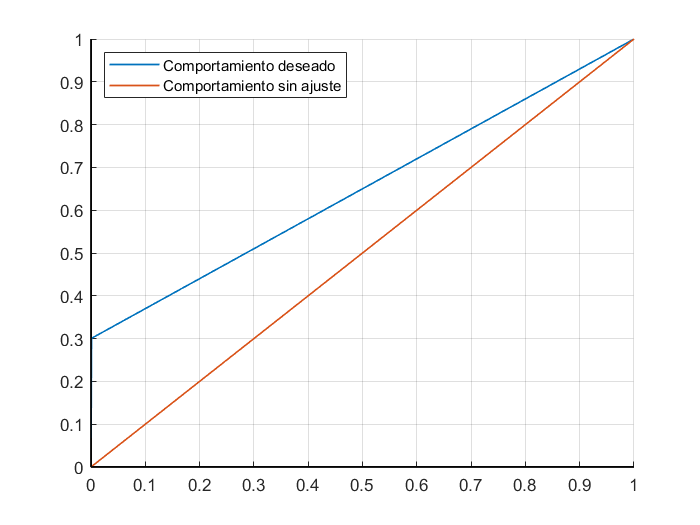

La calibración consiste en encontrar esos valores de ``alpha`` y ``beta`` que permiten a ambos motores moverse aproximadamente a la misma velocidad para un mismo valor de entrada ``x``.

## Proceso de calibración
Primero se van a calibrar los motores usando las librerias que vienen preinstaladas en el Jetbot, que implementan el mecanismo de calibración descrito. Para ello, se siguen los siguientes pasos:

### Comprobación de los valores
Para mover los motores se utiliza un comando de las librerias de control que directamente aplica la expresión ``y = alpha * x + beta``. En este caso los valores de ``alpha`` y ``beta`` son inicialmente 1.0 y 0.0 respectivamente.

Para probar esto, en el siguiente codigo se obtienen los valores de cada parametro tras la inicialización de las librerias de control:

In [1]:
from jetbot import Robot
robot = Robot()

print(f'El valor alpha del motor izquierdo es: {robot.left_motor.alpha}')
print(f'El valor alpha del motor derecho es: {robot.right_motor.alpha}')
print(f'El valor beta del motor izquierdo es: {robot.left_motor.beta}')
print(f'El valor beta del motor derecho es: {robot.right_motor.beta}')

El valor alpha del motor izquierdo es: 1.0
El valor alpha del motor derecho es: 1.0
El valor beta del motor izquierdo es: 0.0
El valor beta del motor derecho es: 0.0


### Calibración de beta
Se comienza calibrando ``beta``. Para la calibración de ``beta``, simplemente se debe combrobar para que valores de ``x`` empieza a moverse cada motor (teniendo en cuenta que en este punto de la calibración ``y = x``). 

Para facilitar la tarea, se configura una interefaz simple que permite probar el movimiento de los motores:

In [2]:
import time
import ipywidgets.widgets as widgets
from IPython.display import display
import traitlets

# crea dos slider con un rango de [-1.0, 1.0]
left_slider = widgets.FloatSlider(description='left', min=-1.0, max=1.0, step=0.01, orientation='vertical')
right_slider = widgets.FloatSlider(description='right', min=-1.0, max=1.0, step=0.01, orientation='vertical')

# crea botones
button_layout = widgets.Layout(width='100px', height='80px', align_self='center')
stop_button = widgets.Button(description='stop', button_style='danger', layout=button_layout, color='red')
run_button = widgets.Button(description='run', layout=button_layout)

# se crea un contenedor donde colocar los sliders y botones
ui_container = widgets.HBox([left_slider, right_slider, run_button, stop_button])

# se muestra el contenedor
display(ui_container)

# finalmente, se conecta el movimiento del robot a los botones, dandoles funcion

# primero se definen las funciones que han de ejecutarse cuando se pulsa cada boton
def force_stop(change):
    robot.right_motor._release()
    robot.left_motor._release()

def run_bot(change):
    robot.set_motors(left_slider.value, right_slider.value)
    time.sleep(2.0)
    robot.right_motor._release()
    robot.left_motor._release()
    
# y se conectan los botones a las acciones
stop_button.on_click(force_stop)
run_button.on_click(run_bot)

El proceso de calibración de ``beta`` consiste en encontrar el mínimo valor de ``x`` mueve los motores desde el reposo. Una vez encontrados los valores, se apuntan para usarlos en la aplicación final.

Es importante tener en cuenta que ``beta`` no es el mismo cuando ambos motores se mueven a la vez que cuando se mueven de uno en uno. Idealmente, en la aplicación final ambos motores siempre se moveran a la vez, por lo que las ``betas`` que obtendremos serán siempre tratando de mover ambos motores a la vez. Esto añade una nueva condición que deben cumplir ambas ``betas``: deben mover ambos motores a la misma velocidad. En caso contrario, encontrariamos un desequilibrio entre los motores que ``alpha`` no podría corregir.

> CUIDADO: Si el robot pierde la conexion justo despues de ejecutar la orden de movimiento pero antes de recibir la de parada, el robot podría empezar a moverse sin control. Para evitar esto, introducimos  un "Heartbeat killswitch" que evitará que el robot se mueva si este se desconecta en algún momento.

In [3]:
from jetbot import Heartbeat

heartbeat = Heartbeat()

# esta funcion es llamada si el estado del heartbeat cambia, es decir, si el robot se desconecta
def handle_heartbeat_status(change):
    if change['new'] == Heartbeat.Status.dead:
        robot.stop()
        
heartbeat.observe(handle_heartbeat_status, names='status')

Para continuar el proceso de calibración, aplicamos el nuevo valor de ``beta`` a cada motor usando los siguientes comandos:

In [4]:
# Resultados obtenidos de beta
robot.left_motor.beta = 0.30
robot.right_motor.beta = 0.37




Podemos comprobar los nuevos valores calibrados a continuacion:

In [5]:
print(f'El valor alpha del motor izquierdo es: {robot.left_motor.alpha}')
print(f'El valor alpha del motor derecho es: {robot.right_motor.alpha}')

print(f'El valor beta del motor izquierdo es: {robot.left_motor.beta}')
print(f'El valor beta del motor derecho es: {robot.right_motor.beta}')

El valor alpha del motor izquierdo es: 1.0
El valor alpha del motor derecho es: 1.0
El valor beta del motor izquierdo es: 0.3
El valor beta del motor derecho es: 0.37


### Calibración de alpha
El último paso para completar la calibración es calibrar alpha. Para ello, se hacen pruebas con valores extremos de ``x``, buscando que los motores se muevan a la misma velocidad para cualquier valor de ``x``. Para ello, se utiliza la misma interfaz del apartado anterior, asegurando que los parametros de ``beta`` hallados en el anterior apartado han sido introducidos en la libreria.

Sin embargo, resulta imposible completar este proceso de forma normal, ya que en el momento en el que se prueban las velocidades negativas el comportamiento del robot empieza a ser erratico.

## Problema de la calibracion original.
El principal problema que se encuentra con este proceso de calibración radica en las librerias utilizadas. ``alpha`` y ``beta`` solo sirven para ajustar una funcion lineal y positiva, lo que impide detener el motor dandole a x un valor de 0 o utilizar correctamente la marcha atras. En la siguiente gráfica se muestra una comparativa entre el comportamiento deseado y el de la librería:

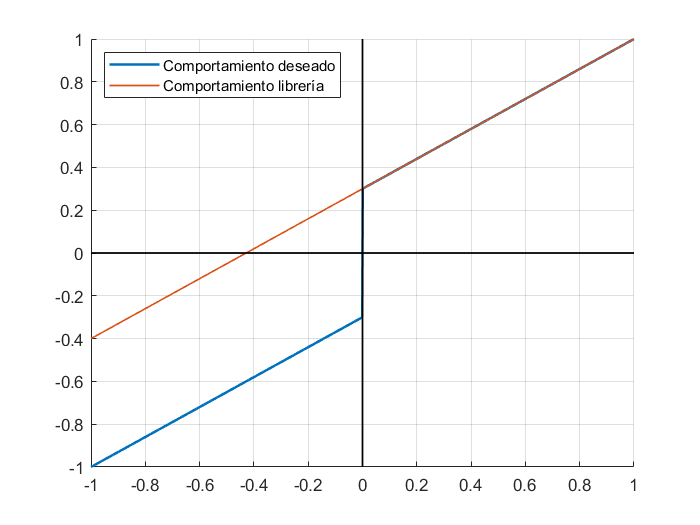

> Este error en las librerias se debe a que el Jetbot nunca fue diseñado para un control fino. Se puede ver claramente como se prefiere el uso de funciones como "forward" o "left" que simplemente le dan un ``x = 1`` al motor correspondiente.

## Solución: Calibración no lineal.
Para solucionar este problema se desarrollan unas librerias propias que introducen una calibracion mas acertada. Estas librerias tendran nuevos parametros de calibración alpha, beta y gamma para cada motor.

Nuestro objetivo es crear un nuevo metodo que reciba valores de ``x`` entre -1 y 1 los cuales de comporten siguiendo las siguientes especificaciones:

* Para valores en el intervalo ``[-gamma, gamma]``, el motor no se moverá, es decir, recibirá un 0. Esto sirve de medida de seguridad por si los joystick estan algo descentrados, por lo que los valores de gamma seran muy pequeños, 0.01 o 0.02.

* Para el resto de valores positivos, el motor recibirá un valor que responde a la función ``y = alpha * (x - gamma) + beta``.

* Para el resto de valores negativos, el motor recibirá un valor que responde a la función ``y = alpha * (x + gamma) - beta``.

Este comportamiento se muestra en la siguiente gráfica:
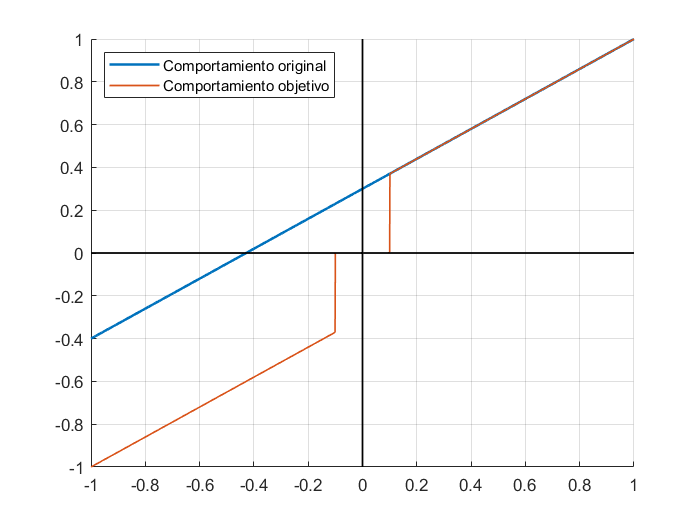

Esta librería tiene dos componentes, cuyo código se muestra a continuación (se recomienda reiniciar el kernel antes de ejecutar este código):
* Una clase Motor, que implementa este comportamiento de forma individual para cada motor.

In [1]:
from Adafruit_MotorHAT import Adafruit_MotorHAT
import time
import atexit

class Motor():
    def __init__(self, driver, channel, alpha, beta, gamma):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        self._driver = driver
        self._motor = self._driver.getMotor(channel)
        if(channel == 1):
            self._ina = 1
            self._inb = 0
        else:
            self._ina = 2
            self._inb = 3
        atexit.register(self._release)
        
    def calibrate(self, alpha, beta, gamma):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def write_speed(self, value):
        """Sets motor value between [-1, 1]"""
        """ primero comprobamos que el valor sea mayor que el coef de seguridad gamma.
        Si es menor, la velocidad sera 0.
        Si es mayor, la velocidad se calculara segun los valores de la calibraci0n"""
        value = - value
        if abs(value) < self.gamma:
            mapped_value = 0
        elif value > 0:
            mapped_value = int(255.0 * (self.alpha * value + self.beta))
        else:
            mapped_value = int(255.0 * (self.alpha * value - self.beta))
        
        speed = min(abs(mapped_value), 255)
        self._motor.setSpeed(speed)
        if mapped_value < 0:
            self._motor.run(Adafruit_MotorHAT.FORWARD)
            self._driver._pwm.setPWM(self._ina,0,0)
            self._driver._pwm.setPWM(self._inb,0,speed*16)
        else:
            self._motor.run(Adafruit_MotorHAT.BACKWARD)
            self._driver._pwm.setPWM(self._ina,0,speed*16)
            self._driver._pwm.setPWM(self._inb,0,0)

    def _release(self):
        """Stops motor by releasing control"""
        self._motor.run(Adafruit_MotorHAT.RELEASE)
        self._driver._pwm.setPWM(self._ina,0,0)
        self._driver._pwm.setPWM(self._inb,0,0)
       

* Una clase robot que implementa el comportamiento para el robot completo, llamando a dos instancias de la clase motor.

In [2]:
class Robot():   
    def __init__(self):
        self.motor_driver = Adafruit_MotorHAT(i2c_bus=1)
        self.left_motor = Motor(self.motor_driver, channel=1, alpha=0.76, beta=0.25, gamma=0.02)
        self.right_motor = Motor(self.motor_driver, channel=2, alpha=0.75, beta=0.26, gamma=0.02)
        
    def set_motors(self, left_speed, right_speed):
        self.left_motor.write_speed(left_speed)
        self.right_motor.write_speed(right_speed)
        
    def forward(self, speed=1.0, duration=None):
        self.left_motor.write_speed(speed)
        self.right_motor.write_speed(speed)

    def backward(self, speed=1.0):
        self.left_motor.write_speed(-speed)
        self.right_motor.write_speed(-speed)

    def left(self, speed=1.0):
        self.left_motor.write_speed(-speed)
        self.right_motor.write_speed(speed)

    def right(self, speed=1.0):
        self.left_motor.write_speed(speed)
        self.right_motor.write_speed(-speed)

    def stop(self):
        self.left_motor.write_speed(0)
        self.right_motor.write_speed(0)
        
    def calibrate_left(self, alpha, beta, gamma):
        self.left_motor.calibrate(alpha, beta, gamma)
        
    def calibrate_right(self, alpha, beta, gamma):
        self.right_motor.calibrate(alpha, beta, gamma)

### Segundo intento de calibración.
Esta nueva librería proveera el comportamiento deseado, como se va a comprobar ahora utilizando el mismo método que antes:

In [3]:
import time
import ipywidgets.widgets as widgets
from IPython.display import display
import traitlets

# Se crea un objeto para controlar el robot con las nuevas clases
robot=Robot()

# crea dos slider con un rango de [-1.0, 1.0]
left_slider = widgets.FloatSlider(description='left', min=-1.0, max=1.0, step=0.01, orientation='vertical')
right_slider = widgets.FloatSlider(description='right', min=-1.0, max=1.0, step=0.01, orientation='vertical')

# crea botones
button_layout = widgets.Layout(width='100px', height='80px', align_self='center')
stop_button = widgets.Button(description='stop', button_style='danger', layout=button_layout, color='red')
run_button = widgets.Button(description='run', layout=button_layout)

# se crea un contenedor donde colocar los sliders y botones
ui_container = widgets.HBox([left_slider, right_slider, run_button, stop_button])

# se muestra el contenedor
display(ui_container)

# finalmente, se conecta el movimiento del robot a los botones, dandoles funcion

# primero se definen las funciones que han de ejecutarse cuando se pulsa cada boton
def force_stop(change):
    robot.right_motor._release()
    robot.left_motor._release()

def run_bot(change):
    robot.set_motors(left_slider.value, right_slider.value)
    time.sleep(2.0)
    robot.right_motor._release()
    robot.left_motor._release()
    
# y se conectan los botones a las acciones
stop_button.on_click(force_stop)
run_button.on_click(run_bot)



Para beta tomamos los valores para los cuales los motores se empiezan a mover sin tener carga de manera consistente.
Para alpha, hacemos pruebas con 0.1, 0.4 y 0.8 de velocidad, buscando que el robot se mueva lo mas recto posible. Repetimos lo mismo con velocidades negativas.
Los resultados obtenidos son:
* beta izquierda 0.23
* beta derecha 0.24
* alpha izquierda 0.87
* alpha derecha 0.8

## Conclusiones